## Preliminaries

In [34]:
# TODO: Recursive feature elimination to improve model and identify features
# TODO: Use harmonic mean (within pair) detection threshold as predictor
# TODO: Make detection threshold model (using features).  Use predicted threshold as predictor

In [1]:
#Gets the updates from the development files you imported
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
#Imports the pands library, the math library, and the init class python file
#Last line: updates matlab library that is used in init file
import __init__ as a
import math
import numpy as np
import matplotlib.pyplot as plt
import pyrfume 
import seaborn as sns
sns.set(font_scale=1.2)
#a.mpl.rcParams['font.size'] = 12

## Start of Project

In [4]:
# This section loads in the data and groups each pair of enantiomers by making them have the same number associated with column "N"
# We also set the Normalized Detection Thresholds to be of the same type as a way of trying to avoid type errors later on
# This section also takes each pair of enantiomers and computes the ratio of the Normalized Detection Thresholds between the two
# The ratio is saved and will be used when the dataset gets cut in half
coleman_smiles = a.load_other_smiles(coleman=True)
coleman_data = a.load_data("coleman")#.iloc[1:]
coleman_data['N'] = np.arange(0, coleman_data.shape[0]/2, 0.5).astype(int)
coleman_data['Normalized Detection Threshold'] = coleman_data['Normalized Detection Threshold'].astype('float')
coleman_data.head()

Loaded 456 molecules


,Molecule Name,Pubchem ID #,Note,SMILES String,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,N
0,(R)-(-)-gamma-ionone,11389922,NaN,CC(=O)/C=C/[C@H]1C(=C)CCCC1(C)C,1.10E+01,ppb water,11.00,"Weak green, fruity, pineapple-like odor with m...",Rows 66-100 are from here: https://www.jstage....,0
1,(S)-(+)-gamma-ionone,11194862,NaN,CC(=O)/C=C/[C@@H]1C(=C)CCCC1(C)C,7.00E-02,ppb water,0.07,"Linear, very pleasant, floral, green, woody od...",Rows 101-121 are from here: https://github.com...,0
2,(4R)-(-)-carvone,439570,NaN,CC1=CC[C@H](CC1=O)C(=C)C,2.00E+00,ppb,2.00,"sweet spearmint, fresh herbal",Rows 122 - 193 are from here: https://github.c...,1
3,(4S)-(+)-carvone,16724,NaN,CC1=CC[C@@H](CC1=O)C(=C)C,1.30E+02,ppb,130.00,"caraway, fresh herbal",Rows 194-223 are from here: https://github.com...,1
4,"(4R,7R)-(+)-galaxolide",14177988,NaN,C[C@H]1COCC2=CC3=C(C=C12)C([C@H](C3(C)C)C)(C)C,4.40E-01,ppb in air,0.44,weak to almost odorless,Rows 224-267 are from here: https://github.com...,2


## Cutting the Dataframe in Half

In [47]:
def harmonic(x):
    return np.log10(1/np.mean(1/x['Normalized Detection Threshold'].values))

In [48]:
# This section creates a new data frame with just one odorant of each enantiomeric pair from the original dataset 
# Adds the ratio of absolute log values
# half_log_abs = coleman_data.groupby('N').apply(log_abs)
half_log_abs = coleman_data.groupby('N').apply(a.log_abs)
half_det = coleman_data.groupby('N').apply(harmonic)
half_coleman_data = coleman_data.iloc[::2].copy()
half_coleman_data.loc[:, 'log_abs'] = half_log_abs.values
half_coleman_data.loc[:, 'det'] = half_det.values

In [49]:
# This line makes sure that the rest of the exsisting null values are equal in the new data frame and in the new data frame's 'log_abs' column
assert half_log_abs.isnull().sum() == half_coleman_data['log_abs'].isnull().sum()

In [50]:
# This line checks that the half dataset was created properly
half_coleman_data.head()

,Molecule Name,Pubchem ID #,Note,SMILES String,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,N,log_abs,det
0,(R)-(-)-gamma-ionone,11389922,NaN,CC(=O)/C=C/[C@H]1C(=C)CCCC1(C)C,1.10E+01,ppb water,11.00,"Weak green, fruity, pineapple-like odor with m...",Rows 66-100 are from here: https://www.jstage....,0,2.196295,-0.856627
2,(4R)-(-)-carvone,439570,NaN,CC1=CC[C@H](CC1=O)C(=C)C,2.00E+00,ppb,2.00,"sweet spearmint, fresh herbal",Rows 122 - 193 are from here: https://github.c...,1,1.812913,0.595429
4,"(4R,7R)-(+)-galaxolide",14177988,NaN,C[C@H]1COCC2=CC3=C(C=C12)C([C@H](C3(C)C)C)(C)C,4.40E-01,ppb in air,0.44,weak to almost odorless,Rows 224-267 are from here: https://github.com...,2,2.643453,-2.699956
6,"(4R,4aS,6R)-(+) nootkatone",1268142,NaN,C[C@@H]1CC(=O)C=C2[C@]1(C[C@@H](CC2)C(=C)C)C,1.50E+01,ppm,15000.00,grapefruit odor,Rows 370-407 are from here: https://github.com...,3,3.643453,4.477023
8,"(2S,4R)-(+) cis-2-methyl-4-propyl-1,3-oxathiane",6931728,NaN,CCC[C@@H]1CCO[C@@H](S1)C,2.00E+00,ppb,2.00,"ctypical sulfurous, with a rubbery onion note;...",Rows 424-435 are from here: https://github.com...,4,0.301030,0.425969


In [51]:
# This section gets rid of all the invalid SMILES Strings, specifically the duplicates because we don't want to count their perceptual features twice and the "nan" values 
half_coleman_data = half_coleman_data.drop_duplicates(subset=['SMILES String'])
half_coleman_data = half_coleman_data[~half_coleman_data['SMILES String'].str.contains('NaN', na=True)]
half_coleman_data = half_coleman_data[~half_coleman_data['SMILES String'].str.contains('nan', na=True)]

In [52]:
# These two assert statements are to ensure that we only have unqiue smiles strings and that no smiles strings are nan values
assert half_coleman_data['SMILES String'].shape == half_coleman_data['SMILES String'].unique().shape, "Number of SMILES strings should equal number of unique SMILES strings at this stage"

In [53]:
# This line makes sure that are no more nan values in the smiles string column
assert sum(half_coleman_data['SMILES String']=='nan') == 0, "There should be no NaN SMILES strings at this point"

In [54]:
#This line gets rid of the rows with a null log_abs value
half_coleman_data = half_coleman_data[~half_coleman_data['log_abs'].isnull()]

In [55]:
#This line makes sure there are no more log_abs values with the value null
assert not sum(half_coleman_data['log_abs'].isnull())
assert not sum(half_coleman_data['det'].isnull())

## Computing the Features

In [13]:
# These lines calculate the mordred and morgan features
mordred_data = a.calculate_features(half_coleman_data, "mordred")
morgan_data = a.calculate_features(half_coleman_data, "morgan")

Convering SMILES string to Mol format...
Computing 3D coordinates...
Removing CC[C@@H](C)[C@H](C(=O)O[C@H]1[C@@H](C(C(=C)[C@@]2([C@@]1([C@H](CC2=O)C3=COC=C3)C)O)[C@@]4([C@H](CC(=O)O[C@]([C@@H]4CC(=O)OC)(C)COC(=O)C)OC(=O)C)C)OC=O)O due to failed embedding
Computing Mordred features...


100%|██████████| 174/174 [00:06<00:00, 26.74it/s]


/home/rgerkin/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
There are 174 molecules and 1826 features
175 similarity features for 9764 molecules


In [14]:
#These lines make sure that we only use the molecules that have mordred and morgan features computed
common_index = mordred_data.index.intersection(morgan_data.index)
mordred_data = mordred_data.loc[common_index]
morgan_data = morgan_data.loc[common_index]

In [15]:
#Data frame that has both the mordred and morgan features
both = mordred_data.join(morgan_data.iloc[:,10:], how="inner")
both.head()

,Molecule Name,Pubchem ID #,Note,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,N,log_abs,...,CC(=O)O.C1=CC=C2C(=C1)C(=CC3=C2N=C4C=CC(=N)C=C4O3)N,CCC(C)N1CCC2(CC1)NC3=C4C5=C(C(=NC(=O)/C(=C/C=C/[C@@H]([C@@H]([C@H]([C@H]([C@H]([C@@H]([C@@H]([C@H](/C=C/O[C@@]6(C(=O)C4=C(O6)C(=C5O)C)C)OC)C)OC(=O)C)C)O)C)O)C)/C)C3=N2)O,C[C@H]1/C=C/C=C(\C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)[C@](O4)(O/C=C/[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)/C=N\N5CCN(CC5)C)/C,C[C@H]1/C=C/C=C(\C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)[C@](O4)(O/C=C/[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)/C=N\N5CCN(CC5)C6CCCC6)/C,COC1=CC(=CC(=C1O)OC)/C=N\N=C/C2=CC(=C(C(=C2)OC)O)OC,C[N+]1=CC=CC=C1/C=N\O.[Cl-],COC(=O)N/N=C\C1=[N+](C2=CC=CC=C2[N+](=C1)[O-])[O-],C1=CC(=C(C(=C1)Cl)CC(=O)NC(=N)N)Cl.Cl,C1(=C(N=C(C(=N1)Cl)N)N)C(=O)NC(=N)N.O.O.Cl,CCCCCCCOC1=C(C=C(C=C1)CC=C)OC
CC(=O)/C=C/[C@H]1C(=C)CCCC1(C)C,(R)-(-)-gamma-ionone,11389922,NaN,1.10E+01,ppb water,11.00,"Weak green, fruity, pineapple-like odor with m...",Rows 66-100 are from here: https://www.jstage....,0,2.196295,...,0.082192,0.093750,0.097087,0.096677,0.076923,0.074074,0.096774,0.080808,0.080808,0.076923
CC1=CC[C@H](CC1=O)C(=C)C,(4R)-(-)-carvone,439570,NaN,2.00E+00,ppb,2.00,"sweet spearmint, fresh herbal",Rows 122 - 193 are from here: https://github.c...,1,1.812913,...,0.104478,0.090909,0.094276,0.087774,0.069444,0.086957,0.107143,0.114943,0.091954,0.101695
C[C@H]1COCC2=CC3=C(C=C12)C([C@H](C3(C)C)C)(C)C,"(4R,7R)-(+)-galaxolide",14177988,NaN,4.40E-01,ppb in air,0.44,weak to almost odorless,Rows 224-267 are from here: https://github.com...,2,2.643453,...,0.116279,0.127168,0.125373,0.117647,0.131868,0.074766,0.080000,0.080000,0.064000,0.102564
C[C@@H]1CC(=O)C=C2[C@]1(C[C@@H](CC2)C(=C)C)C,"(4R,4aS,6R)-(+) nootkatone",1268142,NaN,1.50E+01,ppm,15000.00,grapefruit odor,Rows 370-407 are from here: https://github.com...,3,3.643453,...,0.088608,0.114458,0.118380,0.116618,0.071429,0.064516,0.088235,0.090090,0.072072,0.084507
CCC[C@@H]1CCO[C@@H](S1)C,"(2S,4R)-(+) cis-2-methyl-4-propyl-1,3-oxathiane",6931728,NaN,2.00E+00,ppb,2.00,"ctypical sulfurous, with a rubbery onion note;...",Rows 424-435 are from here: https://github.com...,4,0.301030,...,0.029851,0.064935,0.053872,0.056426,0.027778,0.028986,0.017857,0.022989,0.000000,0.101695


In [16]:
#Gets all Mordred or mogan features that have numeric values and not Null values
#The last line joins the final mordred and morgan features 
finite_mordred = a.finite_features(mordred_data)
finite_morgan = a.finite_features(morgan_data)
both_features = finite_mordred | finite_morgan

## Creating the Models

Text(0, 0.5, 'Number of Enantiomeric Pairs')

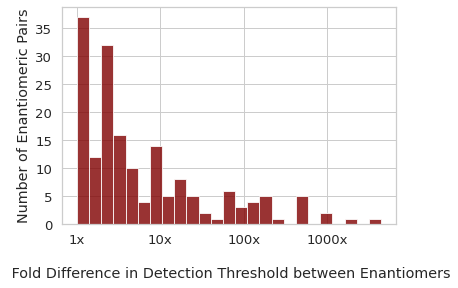

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#sns.set_context('poster')
#plt.figure(figsize=(7,7))
stuff = half_coleman_data[half_coleman_data["log_abs"]<50]
plt.hist(stuff["log_abs"], bins=25, color="#800000", alpha=0.8);
plt.xticks([0,1,2,3], ["1x", "10x", "100x", "1000x"])
plt.xlabel("\n Fold Difference in Detection Threshold between Enantiomers")
plt.ylabel("Number of Enantiomeric Pairs")

In [196]:
#X = both[both_features]; y = both['log_abs']
#X = morgan_data[finite_morgan]; y = morgan_data['log_abs']
X = mordred_data[finite_mordred]; y = mordred_data['log_abs']
X = X.join(half_coleman_data.set_index('SMILES String')['det'])
X = X[y < 10]
y = y[y < 10]
Xn = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

In [67]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.linear_model import ElasticNet
from tqdm.auto import tqdm
#Xn = pd.DataFrame(MinMaxScaler().fit_transform(X), index=X.index, columns=X.columns)
#enr = ElasticNet(alpha=0, l1_ratio=1)
#rfr = RandomForestRegressor(n_estimators=100)
Cs = np.logspace(-3, 3, 13)
rs_in = pd.Series(index=Cs, dtype=float)
rs_out = pd.Series(index=Cs, dtype=float)
rhos_out = pd.Series(index=Cs, dtype=float)
for C in tqdm(Cs):
    svr = SVR(C=C, kernel='rbf')
    clf = svr
    #y_predict = cross_val_predict(rfr, Xn, y, cv=LeaveOneOut(), n_jobs=-1)
    clf.fit(Xn, y)
    y_predict_in = clf.predict(Xn)
    y_predict_out = cross_val_predict(clf, Xn, y, cv=LeaveOneOut(), n_jobs=-1)
    y_predict_in = np.clip(y_predict_in, 0, np.inf)
    y_predict_out = np.clip(y_predict_out, 0, np.inf)
    rs_in[C] = pearsonr(y, y_predict_in)[0]
    rs_out[C] = pearsonr(y, y_predict_out)[0]
    rhos_out[C] = spearmanr(y, y_predict_out)[0]

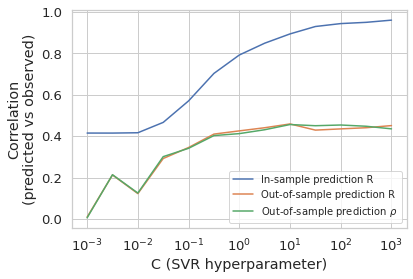

In [68]:
rs_in.plot(label='In-sample prediction R')
rs_out.plot(label='Out-of-sample prediction R')
rhos_out.plot(label=r'Out-of-sample prediction $\rho$')
plt.xscale('log')
plt.ylabel('Correlation\n(predicted vs observed)')
plt.xlabel('C (SVR hyperparameter)')
plt.legend(fontsize=10)

In [212]:
from sklearn.feature_selection import RFE, RFECV
svr = SVR(C=10, kernel='linear')
rfe = RFE(svr, n_features_to_select=1, step=10)
rfe.fit(Xn, y)

RFE(estimator=SVR(C=10, kernel='linear'), n_features_to_select=1, step=10)

In [215]:
rfe.ranking_.max()

108

In [217]:
svr = SVR(C=10, kernel='rbf')
ns = range(1, 109, 1)
rs = pd.Series(index=ns, dtype=float)
for n in tqdm(ns):
    Xn_ = Xn[Xn.columns[rfe.ranking_ <= n]]
    y_predict = cross_val_predict(svr, Xn_, y, cv=LeaveOneOut(), n_jobs=-1)
    rs[n] = np.corrcoef(y, y_predict)[0, 1]

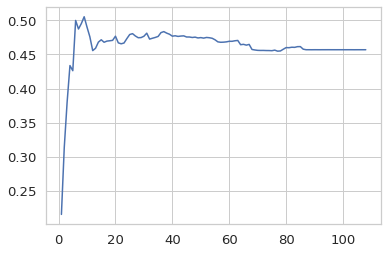

In [218]:
rs.plot()

In [219]:
Cs = np.logspace(-3, 3, 13)
rs_in = pd.Series(index=Cs, dtype=float)
rs_out = pd.Series(index=Cs, dtype=float)
rhos_out = pd.Series(index=Cs, dtype=float)
Xn_ = Xn[Xn.columns[rfe.ranking_ <= 10]]
for C in tqdm(Cs):
    svr = SVR(C=C, kernel='rbf')
    clf = svr
    #y_predict = cross_val_predict(rfr, Xn, y, cv=LeaveOneOut(), n_jobs=-1)
    clf.fit(Xn_, y)
    y_predict_in = clf.predict(Xn_)
    y_predict_out = cross_val_predict(clf, Xn_, y, cv=LeaveOneOut(), n_jobs=-1)
    y_predict_in = np.clip(y_predict_in, 0, np.inf)
    y_predict_out = np.clip(y_predict_out, 0, np.inf)
    rs_in[C] = pearsonr(y, y_predict_in)[0]
    rs_out[C] = pearsonr(y, y_predict_out)[0]
    rhos_out[C] = spearmanr(y, y_predict_out)[0]

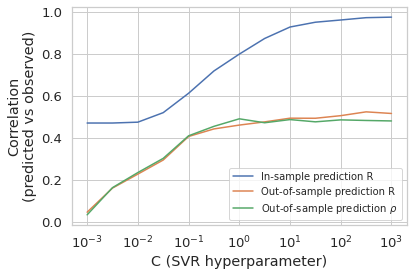

In [220]:
rs_in.plot(label='In-sample prediction R')
rs_out.plot(label='Out-of-sample prediction R')
rhos_out.plot(label=r'Out-of-sample prediction $\rho$')
plt.xscale('log')
plt.ylabel('Correlation\n(predicted vs observed)')
plt.xlabel('C (SVR hyperparameter)')
plt.legend(fontsize=10)

In [223]:
Xn_ = Xn[Xn.columns[rfe.ranking_ <= 10]]
rfr = RandomForestRegressor(n_estimators=100)
y_predict = cross_val_predict(rfr, Xn_, y, cv=LeaveOneOut(), n_jobs=-1)
np.corrcoef(y, y_predict)[0, 1]

0.4943773378589218

In [228]:
rfr.fit(Xn_, y)
pd.Series(rfr.feature_importances_, Xn_.columns).sort_values(ascending=False).head(25)

det            0.182772
ATSC6dv        0.064854
TIC2           0.045709
Xp-5d          0.038744
piPC8          0.033261
ATSC4i         0.024522
GATS5c         0.021889
SsssCH         0.019504
ATSC1p         0.018890
ATSC8d         0.018009
CIC4           0.017888
ATSC8dv        0.017663
MATS5i         0.016666
ATSC4d         0.014975
EState_VSA2    0.014756
AATSC5d        0.014536
RPCG           0.014306
ATSC6p         0.013825
JGI3           0.013622
AATSC1s        0.012984
AATSC3c        0.012602
GATS3c         0.012061
SIC2           0.011795
ATS8v          0.011756
GATS4s         0.010747
dtype: float64

Text(0, 0.5, 'Predicted Detection\nThreshold Ratio')

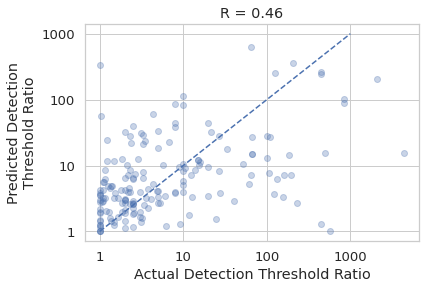

In [197]:
svr = SVR(C=10, kernel='rbf')
svr.fit(Xn, y)
y_predict = cross_val_predict(svr, Xn, y, cv=LeaveOneOut(), n_jobs=-1)
y_predict = np.clip(y_predict, 0, np.inf)
plt.scatter(y, y_predict, alpha=0.3)
plt.plot([0, 3], [0, 3], '--')
plt.title('R = %.2g' % np.corrcoef(y, y_predict)[0, 1])
ticks = range(4)
plt.xticks(ticks, ['%d' % 10**x for x in ticks])
plt.yticks(ticks, ['%d' % 10**x for x in ticks])
plt.xlabel('Actual Detection Threshold Ratio')
plt.ylabel('Predicted Detection\nThreshold Ratio')

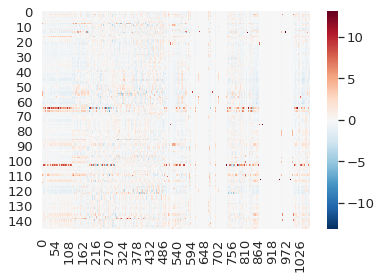

In [203]:
sns.heatmap(svr.support_vectors_, cmap='RdBu_r')

In [78]:
abraham = pyrfume.load_data('abraham_2011/abraham-2011-with-CIDs.csv')
abraham = abraham.dropna(subset=['SMILES'])
from pyrfume.features import smiles_to_mordred
abraham_mordred = smiles_to_mordred(abraham['SMILES'].values)

[-----------------------100%---------------------] 311 out of 311 complete (Finished embedding all molecules)
Computing Mordred features...


100%|██████████| 249/249 [00:08<00:00, 28.93it/s]


There are 249 molecules and 1826 features


In [180]:
#X = abraham_mordred.join(abraham.set_index('SMILES').drop(['Substance', 'Group'], axis=1), how='inner', rsuffix='abr_')
abe_ok = ['MW',
 'Log (1/ODT)',
 'E',
 'S',
 'A',
 'B',
 'L',
 'V',
 'M',
 'AL',
 'AC',
 'ES',
 'C1',
 'C1AC',
 'C1AL',
 'HS',
 'C2',
 'C2Al',
 'C2AC']
X = abraham_mordred.join(abraham.set_index('SMILES')[['Log (1/ODT)']], how='inner', rsuffix='abr_')
y = X['Log (1/ODT)']
X = X.astype('float').drop('Log (1/ODT)', axis=1)
#finite_all = X.dropna(axis=1).columns.intersection(finite_mordred)
X = X[finite_mordred].fillna(0)
X = X.dropna(axis=1)
Xn = X.copy()
Xn[:] = StandardScaler().fit_transform(X)

In [167]:
Cs = np.logspace(-3, 3, 13)
rs_in = pd.Series(index=Cs, dtype=float)
rs_out = pd.Series(index=Cs, dtype=float)
rhos_out = pd.Series(index=Cs, dtype=float)
for C in tqdm(Cs):
    svr = SVR(C=C, kernel='rbf')
    clf = svr
    #y_predict = cross_val_predict(rfr, Xn, y, cv=LeaveOneOut(), n_jobs=-1)
    clf.fit(Xn, y)
    y_predict_in = clf.predict(Xn)
    y_predict_out = cross_val_predict(clf, Xn, y, cv=LeaveOneOut(), n_jobs=-1)
    y_predict_in = np.clip(y_predict_in, 0, np.inf)
    y_predict_out = np.clip(y_predict_out, 0, np.inf)
    rs_in[C] = pearsonr(y, y_predict_in)[0]
    rs_out[C] = pearsonr(y, y_predict_out)[0]
    rhos_out[C] = spearmanr(y, y_predict_out)[0]

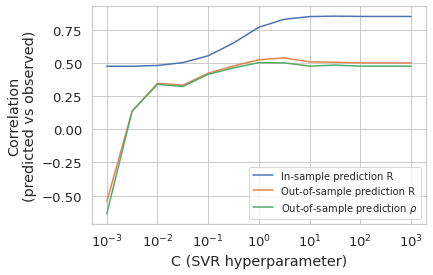

In [168]:
rs_in.plot(label='In-sample prediction R')
rs_out.plot(label='Out-of-sample prediction R')
rhos_out.plot(label=r'Out-of-sample prediction $\rho$')
plt.xscale('log')
plt.ylabel('Correlation\n(predicted vs observed)')
plt.xlabel('C (SVR hyperparameter)')
plt.legend(fontsize=10)

In [184]:
svr = SVR(C=1, kernel='rbf')
svr.fit(Xn, y)
X_ = mordred_data[finite_mordred]; y_ = mordred_data['log_abs']
X_ = X_.join(half_coleman_data.set_index('SMILES String')['det'])
X_ = X_[y_ < 10]
y_ = y_[y_ < 10]
Xn_ = pd.DataFrame(StandardScaler().fit_transform(X_), index=X_.index, columns=X_.columns)
X_['det'] = svr.predict(Xn_.drop('det', axis=1))
#y_predict = cross_val_predict(svr, Xn, y, cv=LeaveOneOut(), n_jobs=-1)

In [188]:
Xn_ = pd.DataFrame(StandardScaler().fit_transform(X_), index=X_.index, columns=X_.columns)
Cs = np.logspace(-3, 3, 13)
rs_in = pd.Series(index=Cs, dtype=float)
rs_out = pd.Series(index=Cs, dtype=float)
rhos_out = pd.Series(index=Cs, dtype=float)
for C in tqdm(Cs):
    svr = SVR(C=C, kernel='rbf')
    clf = svr
    #y_predict = cross_val_predict(rfr, Xn, y, cv=LeaveOneOut(), n_jobs=-1)
    clf.fit(Xn_, y_)
    y_predict_in = clf.predict(Xn_)
    y_predict_out = cross_val_predict(clf, Xn_, y_, cv=LeaveOneOut(), n_jobs=-1)
    y_predict_in = np.clip(y_predict_in, 0, np.inf)
    y_predict_out = np.clip(y_predict_out, 0, np.inf)
    rs_in[C] = pearsonr(y_, y_predict_in)[0]
    rs_out[C] = pearsonr(y_, y_predict_out)[0]
    rhos_out[C] = spearmanr(y_, y_predict_out)[0]

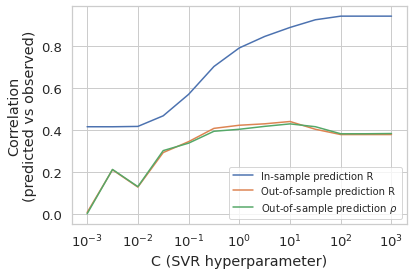

In [189]:
rs_in.plot(label='In-sample prediction R')
rs_out.plot(label='Out-of-sample prediction R')
rhos_out.plot(label=r'Out-of-sample prediction $\rho$')
plt.xscale('log')
plt.ylabel('Correlation\n(predicted vs observed)')
plt.xlabel('C (SVR hyperparameter)')
plt.legend(fontsize=10)